# Rappel  
(dans le cas d'une utilisation sur votre poste personnel)
Avant de commencer, assurez-vous d’avoir Scikit-learn installé (de préférence dans un environnement virtuel en utilisant conda) :
pip install scikit-learn

sinon, à l'insa : 

``` $ source /opt/venv/stpi-m8/bin/activate``` 

``` $ python -m ipykernel install --user --name M8``` 

``` $ jupyter notebook``` 

Nous utilisons un notebook Python. Cet outil est intéressant pour prototyper rapidement du code mais peut s'avérer difficile (car les cellules peuvent être lancées dans un ordre arbitraire et provoquer des effets de bord)

In [1]:
# import nécessaires pour ce TP 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score


# Exemple d'utilisation de pipeline et validation croisée

Dans scikit-learn, un Pipeline est un moyen de chaîner plusieurs étapes de prétraitement et de modélisation dans un processus unique et automatisé. 

- Facilite l'expérimentation : au lieu d'appliquer séparément la standardisation, la réduction de dimension et le modèle, tout est géré dans un même flux de travail.
- Évite la fuite de données : chaque transformation est appliquée uniquement sur l’ensemble d’entraînement, puis utilisée sur l’ensemble de test sans biais.
-  Compatible avec GridSearchCV : permet d’optimiser tous les paramètres du pipeline en une seule recherche.
-  Code plus propre et structuré : plus lisible et maintenable.

En pratique, un pipeline est composé d'une suite d'objets (Transformater et Estimator), chacun appliqué dans l'ordre. Les trois points à retenir : 

- Toutes les étapes sauf la dernière doivent être des transformateurs (avoir une méthode .fit_transform()).
- La dernière étape doit être un estimateur (.fit() et .predict()).
- Le pipeline se comporte ensuite comme un estimateur.

0n pourra faire une validation croisée sur le pipeline et chercher la meilleure combinaison d'hyperparamètres.


In [2]:
# Génération du dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=5, 
                           n_redundant=5, random_state=42)

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichage des dimensions
print(f"Dimensions des données : {X.shape}")

# Définition du pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Normalisation
    ('pca', PCA(n_components=2)),  # Réduction de dimension
    ('svm', SVC(kernel='linear'))   # Classificateur SVM
])

# Entraînement du pipeline
pipeline.fit(X_train, y_train)

# Prédiction
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du pipeline : {accuracy:.2f}")

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Définition des hyperparamètres à optimiser
param_grid = {
    'pca__n_components': [3, 5, 10, 15],  
    'svm__C': [0.1, 1, 10]  
}

# Recherche du meilleur modèle
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1) #validation croisée à 5 folds
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_) #donne le meilleur estimateur

# Évaluation sur le test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Affichage des scores
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy avec les meilleurs paramètres : {best_accuracy:.2f}")
print("\nRapport de classification (modèle optimisé) :")
print(classification_report(y_test, y_pred_best))

#ici le meilleur paramètre est SVM avec une accuracy score de 0.1 et selection de 5 composantes
#Avec SVM l'accuracy est 0.82

Dimensions des données : (1000, 20)
Accuracy du pipeline : 0.77

Rapport de classification :
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        96
           1       0.81      0.72      0.76       104

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.76       200

Meilleurs paramètres : {'pca__n_components': 5, 'svm__C': 0.1}
Accuracy avec les meilleurs paramètres : 0.82

Rapport de classification (modèle optimisé) :
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        96
           1       0.81      0.85      0.83       104

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



# Objectifs

Dans ce TP, nous allons :

    - Utiliser un jeu de données réel pour tester un pipeline de classification.
    - Implémenter un noyau personnalisé pour l'interfacer avec SVC.
    - Construire plusieurs pipelines avec ACP et différents noyaux (linéaire, RBF, personnalisé).
    - Optimiser les hyperparamètres (C, n_components) avec GridSearchCV.
    - Comparer les performances et analyser l'impact du noyau et de l'ACP.

Documentation utile :

    SVM - Support Vector Machine
    PCA - Analyse en Composantes Principales
    Pipeline
    GridSearchCV - Optimisation des hyperparamètres

# Chargement et Préparation des Données

Nous allons travailler sur le dataset Breast Cancer, qui contient :

    30 caractéristiques sur les tumeurs.
    2 classes (bénin ou malin).

- Chargez le dataset et effectuez un split train/test (80% train, 20% test) (on utilisera `train_test_split`)


In [4]:
# Chargement des données
data = load_breast_cancer()
X, y = data.data, data.target


feature_names= data.feature_names
# Affichage des caractéristiques
print("Nom des features :", data.feature_names)
print("Classes :", data.target_names)
print("Dimensions des données :", X.shape)

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Nom des features : ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Classes : ['malignant' 'benign']
Dimensions des données : (569, 30)


# Impact de la standardisation

On se concentre sur les feature suivantes : 0, 5, 10, 15, 20, 25

- afficher leur distribution (via un histogramme) avant et après standardisation


Pour aller plus loin, on pourra se référer à 

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section

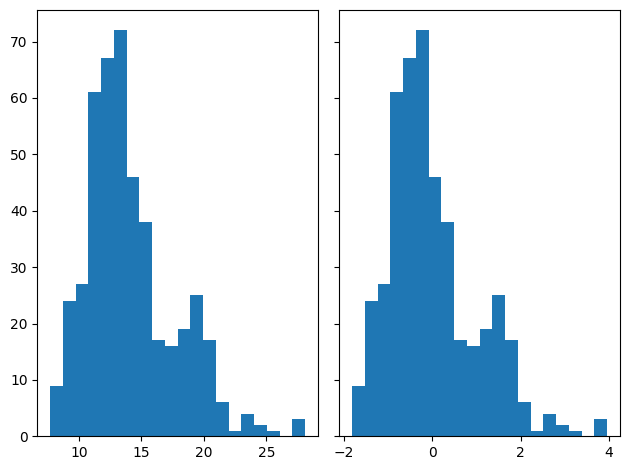

In [25]:
# 🔹 Normalisation avec StandardScaler
scaler = StandardScaler()

# application sur les données de données

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pipeline.fit(X_train_scaled, y_train)

y_pred_scaled = pipeline.predict(X_test_scaled)

# affichage des histogrammes avant/après 

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(X_train[:,0], bins=20)
axs[1].hist(X_train_scaled[:,0], bins=20)

plt.show()

# Implémentation d’un Noyau Personnalisé

Un noyau SVM permet de transformer l'espace des données. Nous allons coder dans une fonctione le noyau hybride (entre RBF et polynomial) :

$
K(x, y) = \exp\left(-\gamma ||x - y||^2\right) + \alpha (x \cdot y + 1)^d
$

On utilisera : $ \gamma = 0.3$, $ \alpha = 0.2 $ et $d = 2$ 

Comme nous allons l'utiliser dans un SVM, On pourra regarder la documentation : 

https://scikit-learn.org/stable/modules/svm.html#svm-kernels



In [31]:
def custom_kernel(X, Y):
    """Noyau hybride : gaussien + polynomiale."""
    gamma = 0.3  # Contrôle la largeur du noyau gaussien
    alpha = 0.2  # Pondération du terme polynomial
    d = 2  # Degré du polynôme

    # a compléter 
    # rbf_svc = svm.SVC(kernel='rbf',gamma = gamma).fit(X, Y)
    # polynomial_svc = svm.SVC(kernel='polynomial',degree = d,coef0 = 1).fit(X,Y)
    # return rbf_svc + alpha * polynomial_svc
    
    #correction 
    euclidian_dist = np.sum((X[:,np.newaxis] - Y[np.newaxis,:])**2 , axis = 2)
    gaussian_term = np.exp(-gamma * euclidiant_dist)
    polynomial_term = alpha * (np.dot(X,Y.T) + 1)**d
    
    return gaussian_term + polynomial_term
    

# Création des Pipelines

A l'intérieur d'une pipeline, nous allons comparer trois modèles :

    SVM Linéaire
    SVM avec noyau rbf
    SVM avec notre noyau personnalisé

In [36]:
# Pipeline avec SVM Linéaire
pipeline_linear = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=2)), 
    ('svm', SVC(kernel='linear'))   # Classificateur SVM linéaire
])

# Pipeline avec SVM RBF
pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('svm', SVC(kernel='rbf'))   # Classificateur SVM RBF
])
# Pipeline avec Noyau Personnalisé
pipeline_custom = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('svm', SVC(kernel=custom_kernel))   # Classificateur SVM noyau personnalisé
])


# Sélection d'hyperparamètres par validation croisée

Nous allons chercher les meilleures valeurs de C et n_components via GridSearchCV.

In [37]:
param_grid = {
    'pca__n_components': [2, 5, 10, 15, 20, 25, 30],  
    'svm__C': [0.1, 1, 10]
}

# GridSearch pour chaque modèle
grid_svm_linear = GridSearchCV(pipeline_linear, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm_rbf = GridSearchCV(pipeline_rbf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_custom_kernel =GridSearchCV(pipeline_custom, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entraînement des modèles
grid_svm_linear.fit(X_train, y_train)
grid_svm_rbf.fit(X_train, y_train)
grid_custom_kernel.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres (SVM Linéaire) :", grid_svm_linear.best_params_)
print("Meilleurs paramètres (SVM RBF) :", grid_svm_rbf.best_params_)
print("Meilleurs paramètres (Noyau Personnalisé) :", grid_custom_kernel.best_params_)


ValueError: 
All the 105 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/venv/stpi-m8-250121/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/venv/stpi-m8-250121/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/venv/stpi-m8-250121/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/venv/stpi-m8-250121/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/venv/stpi-m8-250121/lib/python3.10/site-packages/sklearn/svm/_base.py", line 250, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/opt/venv/stpi-m8-250121/lib/python3.10/site-packages/sklearn/svm/_base.py", line 310, in _dense_fit
    X = self._compute_kernel(X)
  File "/opt/venv/stpi-m8-250121/lib/python3.10/site-packages/sklearn/svm/_base.py", line 508, in _compute_kernel
    kernel = self.kernel(X, self.__Xfit)
  File "/tmp/ipykernel_3466/2306021962.py", line 14, in custom_kernel
NameError: name 'euclidiant_dist' is not defined


# Performances en test

Une fois les pipeline entrainés, on les compare sur les données de test

In [ ]:
# Prédictions
y_pred_linear = grid_svm_linear.best_estimator_.predict(X_test)
y_pred_rbf = grid_svm_rbf.best_estimator_.predict(X_test)
y_pred_custom = grid_custom_kernel.best_estimator_.predict(X_test)

# Calcul du F1-score


# Rapport de classification



# Pour aller plus loin

Nous allons implémenter une ACP pour pouvoir s'interfacer avec sklearn.

Pour rappel, voici les différentes étapes d'une ACP 

    Centrer les données : Soustraire la moyenne de chaque variable.
    Calculer la matrice de covariance.
    Effectuer la décomposition en valeurs propres.
    Ordonner les composantes par variance décroissante.
    Projeter les données sur les nouvelles dimensions.

- Implémenter l'ACP (avec les interfaces adéquates)
- Intégrer votre ACP dans un pipeline (SVM linéaire) et comparer avec les résultats précédents

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        """
        Initialise l'ACP personnalisée.
        :param n_components: Nombre de composantes principales à conserver.
        """
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None

    def fit(self, X, y=None):
        """
        Calcule les composantes principales à partir des données.
        :param X: Matrice de données (n_samples, n_features)
        """
        # 🔹 1. Centrage des données

        # 🔹 2. Calcul de la matrice de covariance

        # 🔹 3. Décomposition en valeurs propres

        # 🔹 4. Trier les valeurs propres (ordre décroissant)

        return self

    def transform(self, X):
        """
        Projette les données sur les axes des composantes principales.
        :param X: Matrice de données (n_samples, n_features)
        :return: X transformé (n_samples, n_components)
        """

    def fit_transform(self, X, y=None):
        """
        Combine fit et transform pour appliquer l'ACP en une seule étape.
        """
        return self.fit(X).transform(X)


In [ ]:
# Pipeline avec SVM Linéaire avec PCA custom 
pipeline_svm_customPCA = Pipeline([
    ('scaler', StandardScaler()),
    ('CustomPCA', CustomPCA(n_components=10)),
    ('svm', SVC(kernel='linear'))
])


